In [1]:
import pathlib
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers



In [2]:
train_stats =pd.read_csv('train_stats_new_1.csv')
train_stats.rename(index={0: 'ACFL', 1: 'MFDR', 2: 'OQ_mean', 3: 'sQ_mean', 4: 'f0', 5: 'H1H2', 6: 'spl'},inplace=True)
labels_train_stats =pd.read_csv('labels_train_stats_new_1.csv')
labels_train_stats.rename(index={0: 'Ps', 1: 'Pc', 2: 'a_TA', 3: 'a_CT', 4: 'a_LCA', 5: 'Wd'},inplace=True)

In [3]:
train_stats

,count,mean,std,min,25%,50%,75%,max
ACFL,13985.0,0.251290,0.215931,0.001040,0.083595,0.184110,0.363971,1.184156
MFDR,13985.0,351.505246,323.652215,1.129353,107.510033,244.876185,498.123962,1794.855798
OQ_mean,13985.0,75.932277,14.259338,28.235294,65.614035,76.237624,87.500000,99.885714
sQ_mean,13985.0,185.318744,72.447506,61.456177,130.701220,158.739220,229.088435,660.869565
f0,13985.0,240.210279,60.292476,60.000000,196.875000,234.574468,270.552147,397.297297
H1H2,13985.0,12.218893,4.334427,-0.000000,9.648654,11.626002,14.003443,35.093616
spl,13985.0,86.028103,12.147025,38.620609,78.392293,86.948502,95.433410,108.470496


In [4]:
labels_train_stats

,count,mean,std,min,25%,50%,75%,max
Ps,13985.0,1022.469765,459.782510,100.311392,656.391006,1029.810854,1402.116172,1872.455911
Pc,13985.0,1341.839897,890.735700,0.012413,627.623883,1151.589994,1823.309200,3999.903599
a_TA,13985.0,0.613700,0.254628,0.000000,0.400000,0.600000,0.800000,1.000000
a_CT,13985.0,0.554144,0.250609,0.000000,0.400000,0.500000,0.800000,1.000000
a_LCA,13985.0,0.561094,0.224819,0.100000,0.400000,0.600000,0.700000,0.900000
Wd,13985.0,8226.556810,15485.944973,0.203673,632.643927,2087.376953,8547.597196,226905.719358


In [5]:
#Load Infield Data
filename='InField_Data_feature_control_NPVH_W'
InField_Data_feature=pd.read_csv(filename + ".csv")

InField_Data_feature


,acflow,mfdr,oq,sq,h1h2,naq,freq,cppall,spl_15cm,isSinging,file_id,subject_id,week
0,575.245314,747.274658,81.578947,181.818182,11.327020,0.226744,292.052980,19.437655,84.975638,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
1,520.729631,696.123730,78.378378,190.000000,9.780783,0.222733,297.972973,21.255754,83.893267,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
2,479.823194,637.637739,83.333333,172.727273,11.609908,0.230982,306.250000,18.425145,83.048218,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
3,435.341464,594.636128,90.000000,190.909091,12.022054,0.232790,317.266187,19.677210,82.200606,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
4,396.851816,551.478456,88.571429,205.000000,11.208119,0.230588,319.565217,19.884673,81.513256,1.0,NF023_20140108_01_IBIF.mat,NF023,W1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100302,147.124509,221.230441,64.150943,290.972222,-3.395176,0.136482,207.042254,27.115497,75.180920,0.0,NF064_20140103_01_IBIF.mat,NF064,W1
3100303,115.051594,105.839300,60.714286,93.750000,0.129877,0.205304,196.000000,27.225596,73.857372,0.0,NF064_20140103_01_IBIF.mat,NF064,W1
3100304,201.533231,271.441658,36.507937,130.000000,5.416392,0.129416,174.308300,24.066355,76.364378,0.0,NF064_20140103_01_IBIF.mat,NF064,W1
3100305,134.661231,175.213833,49.122807,187.373737,0.016762,0.150004,192.576419,24.345462,71.922994,0.0,NF064_20140103_01_IBIF.mat,NF064,W1


In [6]:
#Select data for Week 1 and read file name
InField_Data_feature=InField_Data_feature[InField_Data_feature['week']=='W1']
file_name=InField_Data_feature.file_id.unique()

In [7]:
#Define NN architecture
Neurons=4
def build_model():
  model = keras.Sequential([
    layers.Dense(Neurons, activation='relu', input_shape=[7]),
    layers.Dropout(0.1),
    layers.Dense(Neurons, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(6)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [8]:
# Normalization function
def norm(x):
  return (x - train_stats['min']) / (train_stats['max']- train_stats['min'] )

def norm_labels(x):
  return (x - labels_train_stats['min']) / (labels_train_stats['max']- labels_train_stats['min'] )
      

In [9]:
# Construct and load the trained NN
model = build_model()
model = keras.models.load_model('model_7I_2HL4N_6O.h5')
model.summary()                                 

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_294 (Dense)           (None, 4)                 32        
                                                                 
 dropout_196 (Dropout)       (None, 4)                 0         
                                                                 
 dense_295 (Dense)           (None, 4)                 20        
                                                                 
 dropout_197 (Dropout)       (None, 4)                 0         
                                                                 
 dense_296 (Dense)           (None, 6)                 30        
                                                                 
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Obtain PS, Pc, A_TA, A-CT, A_LCA.
first=1
for file in file_name:
  print(file)
  InField_Data_feature_subject=InField_Data_feature[(InField_Data_feature['file_id']==file)]
  ClinicData =  pd.DataFrame(InField_Data_feature_subject, columns=['acflow','mfdr','oq','sq', 'freq','h1h2', 'spl_15cm'])
  ClinicData = ClinicData.rename(columns = {'acflow': 'ACFL', 'mfdr': 'MFDR', 'oq': 'OQ_mean', 'sq': 'sQ_mean', 'freq': 'f0', 'h1h2': 'H1H2', 'spl_15cm': 'spl'}, inplace = False)
  ClinicData['ACFL']=ClinicData['ACFL']/1000  #from mL/s --> L/s
  ClinicData['spl']=ClinicData['spl']-20*math.log(0.1/0.15,10)  # SPL from 15 cm of the mouth to 10cm of the mouth
  clinic_test_data=ClinicData
  
  normed_clinic_test_data = norm(clinic_test_data)
  clinic_test_predictions_1 = model.predict(normed_clinic_test_data)

  NN_Prediction_norm = pd.DataFrame(clinic_test_predictions_1, columns = ['Ps','Pc','a_TA','a_CT','a_LCA', 'Wd'])
  NN_Prediction_norm['Ps']=NN_Prediction_norm['Ps']*(labels_train_stats['max'][0]- labels_train_stats['min'][0] ) + labels_train_stats['min'][0]
  NN_Prediction_norm['Pc']=NN_Prediction_norm['Pc']*(labels_train_stats['max'][1]- labels_train_stats['min'][1] ) + labels_train_stats['min'][1]
  NN_Prediction_norm['a_TA']=NN_Prediction_norm['a_TA']*(labels_train_stats['max'][2]- labels_train_stats['min'][2] ) + labels_train_stats['min'][2]
  NN_Prediction_norm['a_CT']=NN_Prediction_norm['a_CT']*(labels_train_stats['max'][3]- labels_train_stats['min'][3] ) + labels_train_stats['min'][3]
  NN_Prediction_norm['a_LCA']=NN_Prediction_norm['a_LCA']*(labels_train_stats['max'][4]- labels_train_stats['min'][4] ) + labels_train_stats['min'][4]
  NN_Prediction_norm['Wd']=NN_Prediction_norm['Wd']*(labels_train_stats['max'][5]- labels_train_stats['min'][5] ) + labels_train_stats['min'][5]

  Data_InField_NN=InField_Data_feature_subject.reset_index(drop=True).join(NN_Prediction_norm)
 
  if first==1:
    Data_InField_NN_all=Data_InField_NN
    first=0
  else:
    Data_InField_NN_all=Data_InField_NN_all.append(Data_InField_NN)


NF023_20140108_01_IBIF.mat
NF023_20140107_01_IBIF.mat
NF023_20140106_01_IBIF.mat
NF023_20140105_02_IBIF.mat
NF023_20140105_01_IBIF.mat
NF023_20140104_01_IBIF.mat
NF023_20140103_01_IBIF.mat
NF023_20140102_01_IBIF.mat
NF023_20140101_03_IBIF.mat
NF023_20140101_01_IBIF.mat
NF027_20120110_02_IBIF.mat
NF027_20120110_01_IBIF.mat
NF027_20120109_02_IBIF.mat
NF027_20120109_01_IBIF.mat
NF027_20120108_02_IBIF.mat
NF027_20120108_01_IBIF.mat
NF027_20120107_01_IBIF.mat
NF027_20120106_01_IBIF.mat
NF027_20120103_02_IBIF.mat
NF027_20120103_01_IBIF.mat
NF027_20120102_05_IBIF.mat
NF027_20120102_04_IBIF.mat
NF027_20120102_01_IBIF.mat
NF027_20120101_03_IBIF.mat
NF027_20120101_02_IBIF.mat
NF037_20130122_01_IBIF.mat
NF037_20130121_01_IBIF.mat
NF037_20130120_01_IBIF.mat
NF037_20130119_01_IBIF.mat
NF037_20130109_01_IBIF.mat
NF037_20130108_02_IBIF.mat
NF037_20130108_01_IBIF.mat
NF037_20130107_01_IBIF.mat
NF037_20130101_01_IBIF.mat
NF040_20130108_01_IBIF.mat
NF040_20130107_01_IBIF.mat
NF040_20130106_01_IBIF.mat
N

In [11]:
Data_InField_NN

,acflow,mfdr,oq,sq,h1h2,naq,freq,cppall,spl_15cm,isSinging,file_id,subject_id,week,Ps,Pc,a_TA,a_CT,a_LCA,Wd
0,207.361192,195.304328,78.431373,171.428571,6.731598,0.237033,216.176471,22.640339,81.105612,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,857.457214,912.607178,0.602268,0.476437,0.611327,6218.705078
1,201.317376,231.673391,64.583333,146.153846,8.485070,0.198558,228.497409,21.352255,83.032520,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,1000.338074,1229.739624,0.610668,0.573736,0.636476,5322.315918
2,170.720837,178.993914,70.833333,153.846154,11.033021,0.221931,230.890052,17.155046,80.814469,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,915.539062,1034.278687,0.606056,0.526092,0.635479,5051.875977
3,170.211772,178.751521,74.468085,157.142857,10.365053,0.222840,235.828877,16.706728,79.715579,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,886.926819,963.110107,0.605091,0.497317,0.631672,5707.902832
4,159.073830,176.300703,73.913043,142.857143,10.160206,0.212263,238.378378,15.953965,78.802165,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,877.663879,935.249939,0.605151,0.487003,0.634488,5898.576660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,197.117414,326.208637,35.714286,150.000000,0.021831,0.120211,197.757848,24.074919,80.124150,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,938.033203,1130.133545,0.602948,0.605563,0.637788,1493.018311
2716,147.124509,221.230441,64.150943,290.972222,-3.395176,0.136482,207.042254,27.115497,75.180920,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,809.801147,816.137573,0.597787,0.505539,0.635424,2603.936523
2717,115.051594,105.839300,60.714286,93.750000,0.129877,0.205304,196.000000,27.225596,73.857372,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,752.873535,676.741577,0.595497,0.461134,0.634375,3097.119873
2718,201.533231,271.441658,36.507937,130.000000,5.416392,0.129416,174.308300,24.066355,76.364378,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,752.873535,676.741577,0.595497,0.461134,0.634375,3097.119873


In [12]:
#Delete outlier 
Data_InField_NN= Data_InField_NN.loc[(Data_InField_NN["a_TA"] >0) & (Data_InField_NN["a_TA"] <1) & (Data_InField_NN["a_CT"] >0) & (Data_InField_NN["a_CT"] <1)  & (Data_InField_NN["a_LCA"] >0) & (Data_InField_NN["a_LCA"] <1)  & (Data_InField_NN["Wd"] >0) ]

#Save Results
Data_InField_NN_all.to_csv(filename + "_NN_results.csv")

Data_InField_NN

,acflow,mfdr,oq,sq,h1h2,naq,freq,cppall,spl_15cm,isSinging,file_id,subject_id,week,Ps,Pc,a_TA,a_CT,a_LCA,Wd
0,207.361192,195.304328,78.431373,171.428571,6.731598,0.237033,216.176471,22.640339,81.105612,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,857.457214,912.607178,0.602268,0.476437,0.611327,6218.705078
1,201.317376,231.673391,64.583333,146.153846,8.485070,0.198558,228.497409,21.352255,83.032520,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,1000.338074,1229.739624,0.610668,0.573736,0.636476,5322.315918
2,170.720837,178.993914,70.833333,153.846154,11.033021,0.221931,230.890052,17.155046,80.814469,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,915.539062,1034.278687,0.606056,0.526092,0.635479,5051.875977
3,170.211772,178.751521,74.468085,157.142857,10.365053,0.222840,235.828877,16.706728,79.715579,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,886.926819,963.110107,0.605091,0.497317,0.631672,5707.902832
4,159.073830,176.300703,73.913043,142.857143,10.160206,0.212263,238.378378,15.953965,78.802165,1.0,NF064_20140103_01_IBIF.mat,NF064,W1,877.663879,935.249939,0.605151,0.487003,0.634488,5898.576660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,197.117414,326.208637,35.714286,150.000000,0.021831,0.120211,197.757848,24.074919,80.124150,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,938.033203,1130.133545,0.602948,0.605563,0.637788,1493.018311
2716,147.124509,221.230441,64.150943,290.972222,-3.395176,0.136482,207.042254,27.115497,75.180920,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,809.801147,816.137573,0.597787,0.505539,0.635424,2603.936523
2717,115.051594,105.839300,60.714286,93.750000,0.129877,0.205304,196.000000,27.225596,73.857372,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,752.873535,676.741577,0.595497,0.461134,0.634375,3097.119873
2718,201.533231,271.441658,36.507937,130.000000,5.416392,0.129416,174.308300,24.066355,76.364378,0.0,NF064_20140103_01_IBIF.mat,NF064,W1,752.873535,676.741577,0.595497,0.461134,0.634375,3097.119873


Text(0.5, 1.0, 'Wd')

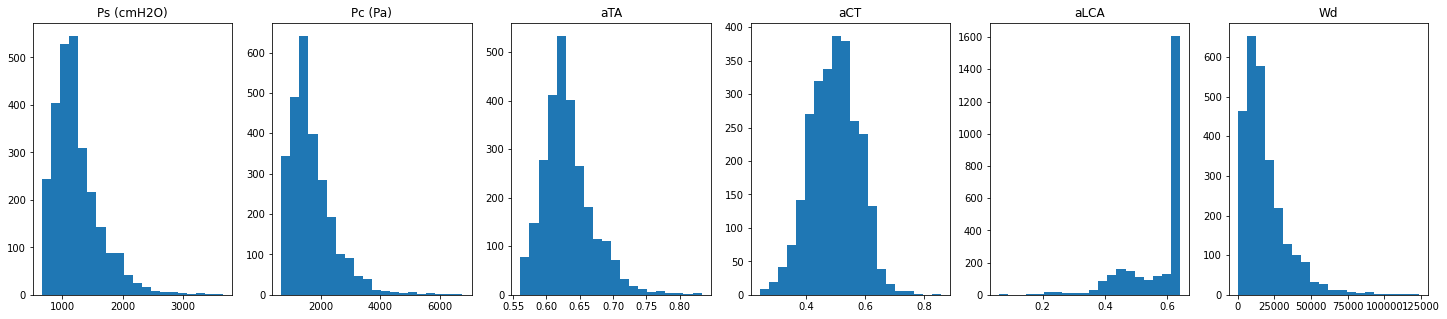

In [13]:
# Plot histogram of NN outputs
fig, axs = plt.subplots(1, 6)
fig.set_size_inches(25, 5)
bins=20;

axs[0].hist(Data_InField_NN["Ps"],bins)
axs[0].set_title('Ps (cmH2O)') 

axs[1].hist(Data_InField_NN["Pc"],bins)
axs[1].set_title('Pc (Pa)') 

axs[2].hist(Data_InField_NN["a_TA"],bins)
axs[2].set_title('aTA') 

axs[3].hist(Data_InField_NN["a_CT"],bins)
axs[3].set_title('aCT') 

axs[4].hist(Data_InField_NN["a_LCA"],bins)
axs[4].set_title('aLCA') 

axs[5].hist(Data_InField_NN["Wd"],bins)
axs[5].set_title('Wd') 

